In [11]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, Embedding
from tensorflow.keras.models import Model

In [12]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [13]:
df=pd.read_csv('spam.csv', encoding="ISO-8859-1")

In [14]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:
df=df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"],axis=1)

In [16]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
df.columns=["Label","data"]

In [18]:
df.head()

,Label,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
#creating binary label
df['b_labels'] = df['Label'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [20]:
df_train,df_test,Ytrain,Ytest=train_test_split(df['data'],Y,test_size=0.33)

In [21]:
MAX_VOCAB_SIZE=20000
tokenizer=Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train=tokenizer.texts_to_sequences(df_train)
sequences_test=tokenizer.texts_to_sequences(df_test)

In [22]:
word2idx=tokenizer.word_index
V=len(word2idx)
print('Found %s unique tokens.' % V)


Found 7199 unique tokens.


In [23]:
#now we need to pad sequences so that we get a nxt matrix
data_train=pad_sequences(sequences_train)
print('Shape of data train tensor:',data_train.shape)
T=data_train.shape[1]

Shape of data train tensor: (3733, 121)


In [26]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 121)


In [27]:
#creating the model
D=20
#hidden state dimension
M=15

#the size of the embedding should be (V+1)xD coz the 1st index is from 1 and not 0 
#thus if final index is V  then actual index would be V+1

i=Input(shape=(T,))
x=Embedding(V+1,D)(i)
x=LSTM(M, return_sequences=True)(x)
x=GlobalMaxPooling1D()(x)
x=Dense(1, activation='sigmoid')(x)

model=Model(i,x)

In [28]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training Model......')
r=model.fit(
    data_train,
    Ytrain,
    epochs=10,
    validation_data=(data_test,Ytest)
)

Training Model......
Epoch 1/10
117/117 [==============================] - 9s 20ms/step - loss: 0.4533 - accuracy: 0.8610 - val_loss: 0.3889 - val_accuracy: 0.8684
Epoch 2/10
117/117 [==============================] - 2s 16ms/step - loss: 0.3936 - accuracy: 0.8647 - val_loss: 0.3768 - val_accuracy: 0.8684
Epoch 3/10
117/117 [==============================] - 2s 16ms/step - loss: 0.3358 - accuracy: 0.8647 - val_loss: 0.2915 - val_accuracy: 0.8684
Epoch 4/10
117/117 [==============================] - 2s 17ms/step - loss: 0.2490 - accuracy: 0.8682 - val_loss: 0.1865 - val_accuracy: 0.9337
Epoch 5/10
117/117 [==============================] - 2s 16ms/step - loss: 0.1381 - accuracy: 0.9796 - val_loss: 0.1144 - val_accuracy: 0.9859
Epoch 6/10
117/117 [==============================] - 2s 17ms/step - loss: 0.0778 - accuracy: 0.9904 - val_loss: 0.0812 - val_accuracy: 0.9859
Epoch 7/10
117/117 [==============================] - 2s 17ms/step - loss: 0.0484 - accuracy: 0.9936 - val_loss: 0.0679 -

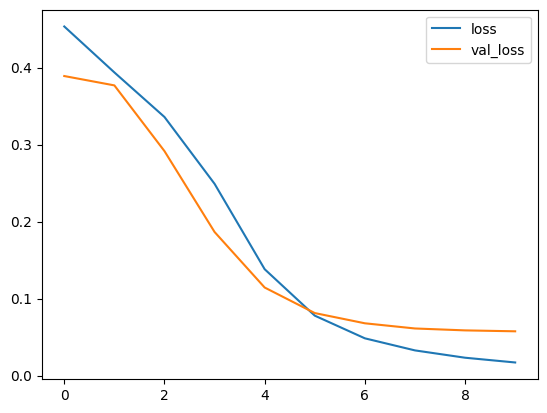

In [29]:
import matplotlib.pyplot as plt 
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

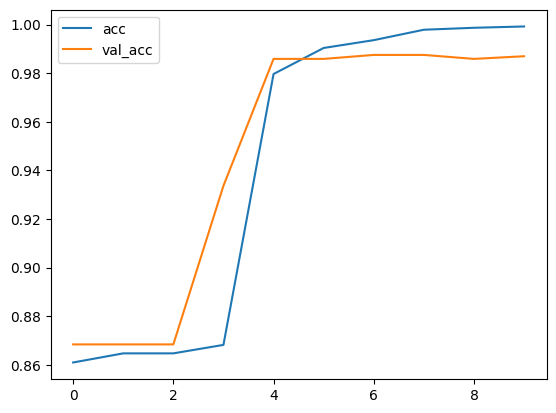

In [30]:
plt.plot(r.history['accuracy'],label='acc')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()

In [33]:
# Make predictions on the test set
predictions = model.predict(data_test)
predictions = (predictions > 0.4).astype(int)

# Convert predictions and actual values to labels
predicted_labels = predictions.flatten()
actual_labels = Ytest

# Create a DataFrame to hold the test data, actual labels, and predicted labels
results = pd.DataFrame({
    'Text': df_test,
    'Actual Label': actual_labels,
    'Predicted Label': predicted_labels
})

# Map numeric labels back to original 'ham'/'spam' labels
label_map = {0: 'ham', 1: 'spam'}
results['Actual Label'] = results['Actual Label'].map(label_map)
results['Predicted Label'] = results['Predicted Label'].map(label_map)

# Display a few examples
print("Some examples of classification results:")
print(results.sample(10))  # Display 10 random samples

# Visualize the results using matplotlib
def visualize_predictions(results, num_samples=10):
    sample_results = results.sample(num_samples)
    for i, row in sample_results.iterrows():
        print(f"Text: {row['Text']}")
        print(f"Actual Label: {row['Actual Label']}")
        print(f"Predicted Label: {row['Predicted Label']}")
        print('-' * 50)

# Call the function to visualize predictions
visualize_predictions(results)


58/58 [==============================] - 0s 8ms/step
Some examples of classification results:
                                                   Text Actual Label  \
58                               Tell where you reached          ham   
2047  No de. But call me after some time. Ill tell y...          ham   
1031                                  Yup bathe liao...          ham   
2178  I don,t think so. You don't need to be going o...          ham   
3931                     Sos! Any amount i can get pls.          ham   
1313            How abt making some of the pics bigger?          ham   
472   Nothing. I meant that once the money enters yo...          ham   
719   Macha dont feel upset.i can assume your mindse...          ham   
1675  Painful words- \I thought being Happy was the ...          ham   
2919  Thanx 4 the time weåÕve spent 2geva, its bin m...          ham   

     Predicted Label  
58               ham  
2047             ham  
1031             ham  
2178             ham 